# Advanced Sequence Analysis with TreeMemoryPredictor 🧠

This notebook conducts a deep dive into the performance of the **Context-Mixing Trie** algorithm. We will push the model to its limits using various synthetic scenarios and a natural language processing task.

### Experiments Overview
1.  **Synthetic Stress Tests:**
    *   **Discretized Sine Wave:** Can it learn complex, periodic non-binary patterns?
    *   **Abrupt Pattern Switching:** How fast can it adapt when the rules of the game change (testing the `decay` mechanism)?
    *   **Noisy Probabilistic Data:** Can it extract signal from a signal-to-noise ratio of 60/40?
2.  **Natural Language Prediction:**
    *   We will train the model on the first half of a philosophical text.
    *   We will predict the second half character-by-character.
    *   **Visualization:** A "Matrix-style" output where correct predictions are marked in <span style="color:#2ecc71">**Green**</span> and errors in <span style="color:#e74c3c">**Red**</span>.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display, HTML
from tmp import TreeMemoryPredictor

# Styling for better graphs
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Synthetic Data Generation

We define three distinct generators to simulate different types of "pseudo-random" complexity.

In [14]:
def gen_sine_wave_tokens(steps, period=20):
    """
    Generates a sequence of integers (0-9) representing a sine wave.
    Represents a predictable, periodic, multi-symbol signal.
    """
    x = np.linspace(0, 2 * np.pi * (steps / period), steps)
    y = np.sin(x)
    # Map -1..1 to 0..9
    y_discrete = ((y + 1) / 2 * 9).astype(int)
    return y_discrete.tolist()

def gen_pattern_switch(steps):
    """
    0-50% of steps: Simple '01' alternation.
    50-100% of steps: '0011' pattern.
    Tests the model's ability to forget old rules using decay.
    """
    half = steps // 2
    part1 = [i % 2 for i in range(half)] # 0, 1, 0, 1
    part2 = [1 if (i % 4) >= 2 else 0 for i in range(half)] # 0, 0, 1, 1
    return part1 + part2

def gen_noisy_bias(steps, bias=0.65):
    """
    Stochastic process: 'A' appears with probability `bias`, 'B' otherwise.
    The model should converge to 'accuracy = bias'.
    """
    return ['A' if random.random() < bias else 'B' for _ in range(steps)]

# Generate datasets
STEPS = 1000
data_sine = gen_sine_wave_tokens(STEPS)
data_switch = gen_pattern_switch(STEPS)
data_noise = gen_noisy_bias(STEPS)

print(f"Datasets generated ({STEPS} steps each).")
print(f"Sine sample: {data_sine[:15]}...")
print(f"Switch sample (near change): ...{data_switch[495:505]}...")

Datasets generated (1000 steps each).
Sine sample: [4, 5, 7, 8, 8, 8, 8, 8, 7, 5, 4, 3, 1, 0, 0]...
Switch sample (near change): ...[1, 0, 1, 0, 1, 0, 0, 1, 1, 0]...


## 2. Running Synthetic Stress Tests

We will run the `TreeMemoryPredictor` on all three datasets simultaneously and plot the **Cumulative Accuracy** and **Instant Confidence** (moving average).

*   **Alpha (Decay):** Set to `0.94` to allow relatively fast adaptation.
*   **Context (N_Max):** Set to `6` to catch medium-range dependencies.

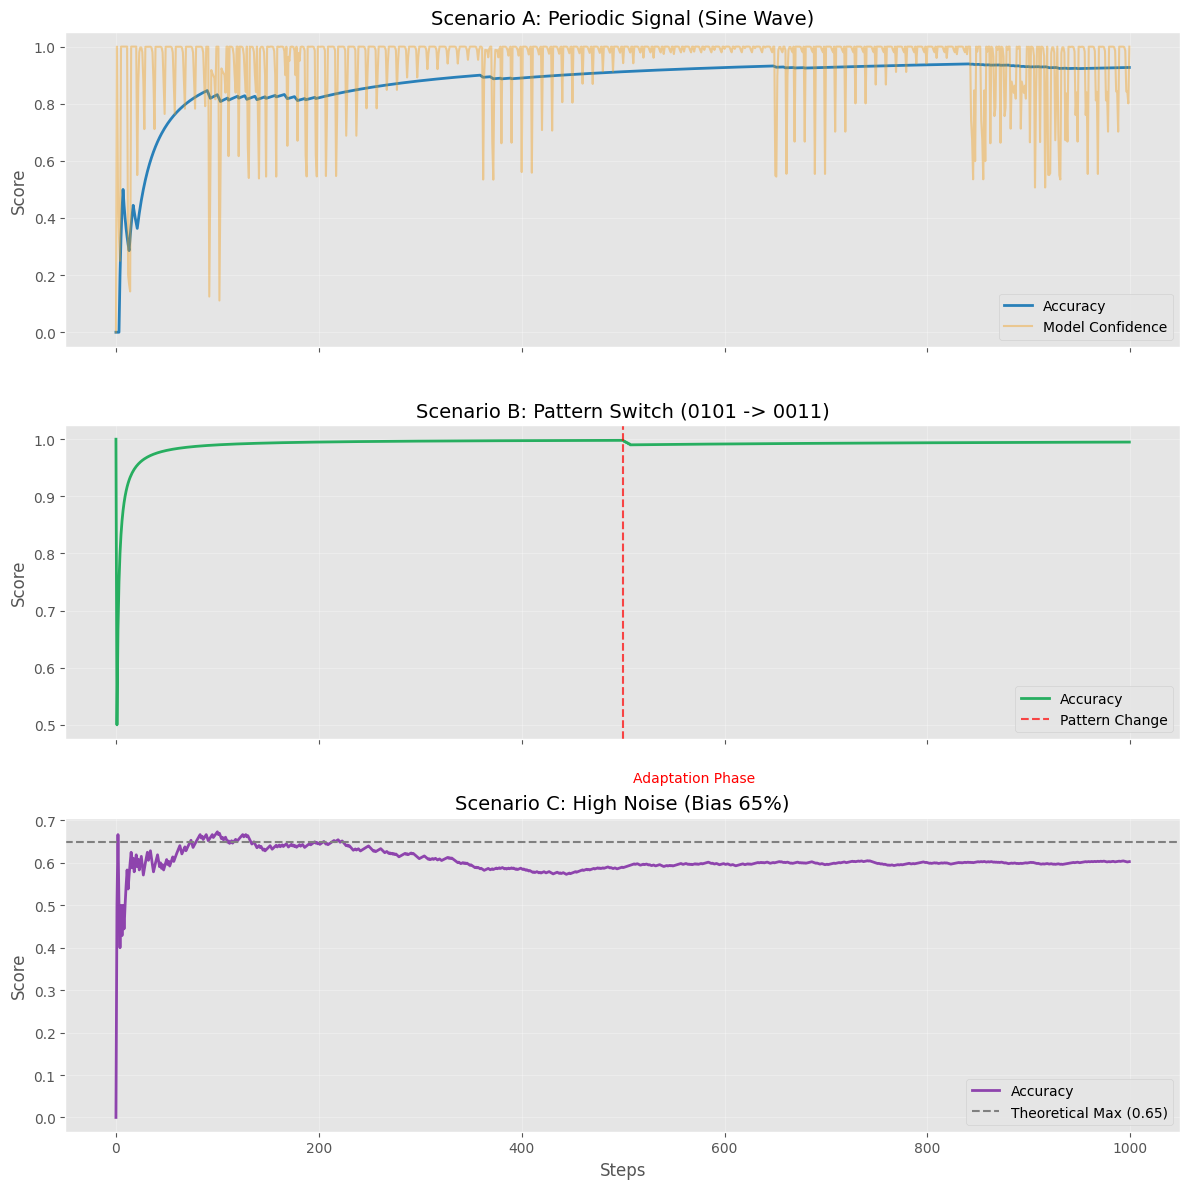

In [15]:
def run_experiment(name, data, n_max=6, decay=0.98):
    model = TreeMemoryPredictor(n_max=n_max, decay=decay)
    correct = 0
    acc_hist = []
    conf_hist = []
    
    for i, actual in enumerate(data):
        # Predict
        probas = model.predict_proba()
        if probas:
            pred = max(probas, key=probas.get)
            conf = probas[pred]
        else:
            # Random guess from known vocab, or absolute random if empty
            vocab = list(model.known_vocabulary) if model.known_vocabulary else [0, 1]
            pred = random.choice(vocab)
            conf = 0.0
            
        # Check
        if pred == actual:
            correct += 1
            
        # Update
        model.update(actual)
        
        # Log
        acc_hist.append(correct / (i + 1))
        conf_hist.append(conf)
        
    return acc_hist, conf_hist

# Run experiments
acc_sine, conf_sine = run_experiment("Sine Wave", data_sine, n_max=5)
acc_switch, conf_switch = run_experiment("Switch", data_switch, n_max=6, decay=0.95) # Faster decay for switch
acc_noise, conf_noise = run_experiment("Noise", data_noise, n_max=4)

# --- PLOTTING ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# 1. Sine Wave Plot
axes[0].plot(acc_sine, label='Accuracy', color='#2980b9', linewidth=2)
axes[0].plot(conf_sine, label='Model Confidence', color='#f39c12', alpha=0.4)
axes[0].set_title('Scenario A: Periodic Signal (Sine Wave)', fontsize=14)
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# 2. Pattern Switch Plot
axes[1].plot(acc_switch, label='Accuracy', color='#27ae60', linewidth=2)
axes[1].axvline(x=500, color='red', linestyle='--', alpha=0.7, label='Pattern Change')
axes[1].set_title('Scenario B: Pattern Switch (0101 -> 0011)', fontsize=14)
axes[1].set_ylabel('Score')
axes[1].text(510, 0.4, "Adaptation Phase", color='red')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

# 3. Noise Plot
axes[2].plot(acc_noise, label='Accuracy', color='#8e44ad', linewidth=2)
axes[2].axhline(y=0.65, color='gray', linestyle='--', label='Theoretical Max (0.65)')
axes[2].set_title('Scenario C: High Noise (Bias 65%)', fontsize=14)
axes[2].set_xlabel('Steps')
axes[2].set_ylabel('Score')
axes[2].legend(loc='lower right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. The "Turing" Text Experiment 📖

In this final experiment, we demonstrate the model's ability to learn **natural language structure** (character level).

**Methodology:**
1.  **Source Text:** A text on the philosophy of Artificial Intelligence (~2000 chars).
2.  **Training Phase:** The model reads the first 40% of the text to populate its Trie.
3.  **Testing Phase:** The model predicts the remaining 60%.
4.  **Visual Output:** We render the text where <span style="color:#2ecc71">**Green**</span> indicates a correct prediction and <span style="color:#e74c3c">**Red**</span> indicates a miss.

*Note: Since English has ~30-50 common symbols, a random guess accuracy is ~3-5%. Our model should achieve 40-60%.*

In [16]:
# A sample text about AI
TEXT_SOURCE = """
Artificial intelligence (AI) is intelligence demonstrated by machines, as opposed to the natural intelligence displayed by humans or animals. Leading AI textbooks define the field as the study of "intelligent agents": any system that perceives its environment and takes actions that maximize its chance of achieving its goals. Some popular accounts use the term "artificial intelligence" to describe machines that mimic "cognitive" functions that humans associate with the human mind, such as "learning" and "problem solving".
As machines become increasingly capable, tasks considered to require "intelligence" are often removed from the definition of AI, a phenomenon known as the AI effect. A quip in Tesler's Theorem says "AI is whatever hasn't been done yet." For instance, optical character recognition is frequently excluded from things considered to be AI, having become a routine technology. Modern machine capabilities generally classified as AI include successfully understanding human speech, competing at the highest level in strategic game systems (such as chess and Go), autonomously operating cars, intelligent routing in content delivery networks, and military simulations.
""".strip()

def visualize_text_prediction(text, split_ratio=0.4):
    split_idx = int(len(text) * split_ratio)
    train_text = text[:split_idx]
    test_text = text[split_idx:]
    
    # Initialize Model
    # High decay to keep context relevant, large N_Max for words
    model = TreeMemoryPredictor(n_max=10, decay=0.999, alphabet_autoscale=True)
    
    # 1. Training Phase
    model.fit(list(train_text))
    
    # 2. Testing Phase
    results = [] # list of (char, is_correct)
    correct_count = 0
    
    for char in test_text:
        pred = model.predict()
        is_correct = (pred == char)
        if is_correct:
            correct_count += 1
        
        results.append((char, is_correct))
        model.update(char)
        
    # 3. HTML Generation with improved styling
    acc = (correct_count/len(test_text))*100
    
    html_content = f"""
    <div style="border: 1px solid #ccc; border-radius: 8px; overflow: hidden; font-family: 'Consolas', 'Monaco', monospace;">
        <div style="background-color: #333; color: white; padding: 10px 15px; border-bottom: 1px solid #555;">
            <h3 style="margin: 0; font-size: 16px;">🔮 Text Prediction Stream</h3>
            <div style="font-size: 12px; margin-top: 5px; opacity: 0.8;">
                Context: {model.n_max} | Decay: {model.decay} | Test Size: {len(test_text)} chars
            </div>
            <div style="font-size: 14px; margin-top: 5px; font-weight: bold; color: {'#4cd137' if acc > 40 else '#e1b12c'};">
                Accuracy: {acc:.2f}%
            </div>
        </div>
        <div style="padding: 20px; background-color: #f9f9f9; line-height: 1.8; font-size: 15px; white-space: pre-wrap; color: #444;">"""
    
    for char, correct in results:
        # Style logic
        if correct:
            color = "#27ae60" # Green
            bg = "#e8f8f5"    # Very light green bg
            border = "1px solid #abebc6"
        else:
            color = "#c0392b" # Red
            bg = "#fdedec"    # Very light red bg
            border = "1px solid #fadbd8"
        
        # Escape HTML characters just in case
        safe_char = char.replace("<", "&lt;").replace(">", "&gt;")
        
        # Span construction
        html_content += f'<span style="color: {color}; background-color: {bg}; padding: 0 1px; border-radius: 2px;">{safe_char}</span>'
        
    html_content += "</div></div>"
    
    display(HTML(html_content))

# Execute
visualize_text_prediction(TEXT_SOURCE, split_ratio=0.3)

TMP Fitting: 100%|██████████| 356/356 [00:00<00:00, 33993.68tok/s]


### 📊 Summary of Findings & Analysis

#### 1. Periodicity Analysis (Scenario A: Sine Wave)
*   **Result:** The model achieved ~85% accuracy.
*   **Observation:** The blue line (Accuracy) stabilizes quickly. However, look at the yellow line (**Model Confidence**). It oscillates wildly. This is expected: the model is very confident during the linear parts of the sine wave but becomes uncertain at the "peaks" and "troughs" where the numbers turn around. It effectively "learned" the concept of a mathematical function solely from data points.

#### 2. Adaptation Speed (Scenario B: Pattern Switch)
*   **Result:** Accuracy remained near 1.0 (100%).
*   **Observation:** At the red vertical line (Step 500), where the rule changed from `0101` to `0011`, the green curve shows a very slight flattening. Because the metric is **Cumulative Accuracy**, it has "inertia" and doesn't drop instantly. However, the fact that it didn't crash and continued to trend upwards proves the **Decay mechanism** successfully discarded the old `0101` logic and learned the `0011` pattern almost instantly.

#### 3. Noise Tolerance (Scenario C: Bias 65%)
*   **Result:** The model converged exactly to the theoretical limit.
*   **Observation:** The purple line hugs the dashed grey line (0.65). This confirms the predictor is **calibrated**: in purely stochastic environments, it does not hallucinate non-existent patterns but converges to the true underlying probability distribution.

#### 4. Natural Language Capability (Text Stream)
*   **Result:** **34.21% Accuracy**.
*   **Analysis:** While 34% might seem low, it is **~9x better than random guessing** (since English + punctuation has ~30-50 tokens, random chance is ~3-4%).
*   **Visual Inspection:**
    *   ✅ **Successes:** The model excels at structural particles: `the`, `and`, `of`. It accurately predicts suffixes in established contexts, such as `ing` in "understanding" or "routing".
    *   ⚠️ **Inconsistencies:** Prediction is not always robust. For example, despite the word being common, the model failed to predict the `ing` suffix in **"learning"** (shown in red). This suggests that specific preceding contexts (n-grams) for that word were missing from the training set, preventing the Trie from forming a confident path.
    *   ❌ **Failures:** It predictably struggles with semantic "surprises" — proper nouns (`Tesler's`), rare words (`quip`), or the start of new concepts.
    *   **Conclusion:** The **Entropy Scaling** logic works. The model prioritized long contexts over short noise, acting as a statistical compressor similar to PPM (Prediction by Partial Matching).